# Damping value cross validation
The choice of the damping value used in the inversion directly affects the results and therefore needs to be carefully chosen. We provide some tools to perform a cross-validation with a range of damping values in order to chose the optimal value.

This cross validation routine is adapted from *Uieda & Barbosa 2017* (DOI: 10.1093/gji/ggw390). See their paper for a detailed discussion.

The main idea is to re-sample the gravity data at a finer resolution and seperate the data into a `testing` and `training` set. The inversion is performed with a range of damping values, each time using just the `training` set. Each resulting inverted topo from each of the damping values is then forward modelled onto the locations of the `testing` data, which were not included in the inversion. The optimal damping value is the one which results in the smallest difference between the forward modeled data and the `testing` data. 

## Import packages

In [21]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2


import logging

import numpy as np
import verde as vd
import xarray as xr
from antarctic_plots import utils as ap_utils

from invert4geom import cross_validation, inversion, plotting, synthetic, utils

# set Python's logging level to suppress information about the inversion\s progress
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create observed gravity data

### True topography

In [22]:
# set grid parameters
spacing = 1000
region = [0, 40000, 0, 30000]

# create synthetic topography data
true_topography = synthetic.synthetic_topography_simple(
    spacing,
    region,
)

### Prism layer

In [23]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
density_contrast = 2670 - 1

# prisms are created between the mean topography value and the height of the topography
zref = true_topography.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(true_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
prisms = utils.grids_to_prisms(
    true_topography,
    zref,
    density=density,
)

### Forward gravity of prism layer

In [24]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

grav_df["observed_grav"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/1271 [00:00<?, ?it/s]

,northing,easting,upward,observed_grav
0,0.0,0.0,1000.0,9.534643
1,0.0,1000.0,1000.0,10.422834
2,0.0,2000.0,1000.0,9.949973
3,0.0,3000.0,1000.0,9.269279
4,0.0,4000.0,1000.0,8.532160
...,...,...,...,...
1266,30000.0,36000.0,1000.0,3.332716
1267,30000.0,37000.0,1000.0,3.330307
1268,30000.0,38000.0,1000.0,3.335438
1269,30000.0,39000.0,1000.0,3.300721


### Resample to create testing / training data sets

In [26]:
# resample to half spacing
grav_df = cross_validation.resample_with_test_points(spacing, grav_df, region)
grav_df

,northing,easting,test,upward,observed_grav
0,0.0,0.0,False,1000.0,9.534643
1,0.0,500.0,True,1000.0,10.063805
2,0.0,1000.0,False,1000.0,10.422834
3,0.0,1500.0,True,1000.0,10.284459
4,0.0,2000.0,False,1000.0,9.949973
...,...,...,...,...,...
4936,30000.0,38000.0,False,1000.0,3.335438
4937,30000.0,38500.0,True,1000.0,3.346051
4938,30000.0,39000.0,False,1000.0,3.300721
4939,30000.0,39500.0,True,1000.0,3.104991


## Gravity misfit

As in the last notebook, for simplicity here we assume that we know the true density contrast and the reference level of the true topography, and use these values to create our starting model. Note that in a real world scenario, these would be unknowns which would need to be carefully chosen, as explained in the following notebooks.

In [27]:
# create flat topography grid with a constant height equal the mean of the starting
# topography (zref)
starting_topography = xr.full_like(true_topography, zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

# gravity of starting model is 0 since its flat, so observed_grav = misfit
grav_df["misfit"] = grav_df["observed_grav"]

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and the
# full misfit is equal to the residual misfit.

# set regional misfit to 0
grav_df["reg"] = 0

# set the residual misfit to the full misfit
grav_df["res"] = grav_df.misfit

## Get Cross Validation Score

We will perform an inversion with a single damping value and calculate a `score` for it.

  0%|          | 0/3670 [00:00<?, ?it/s]

returning original grid
returning original grid


3.297364447712401

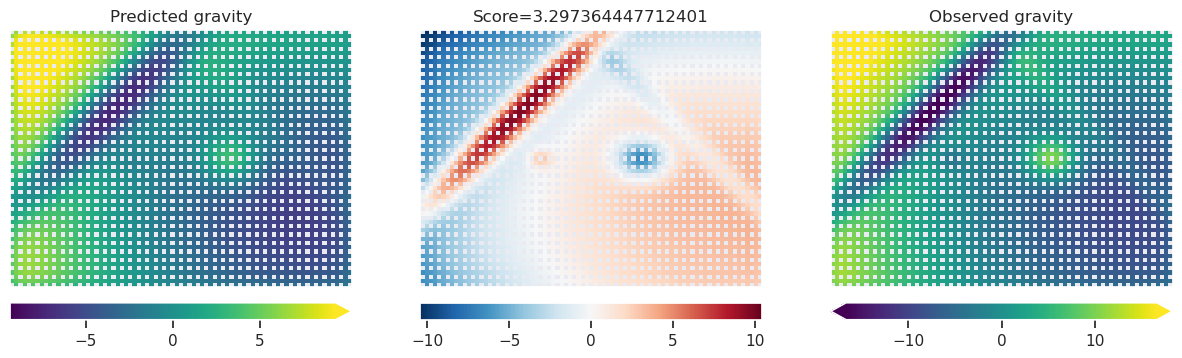

In [28]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "input_grav_column": "observed_grav",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    "zref": zref,
    "density_contrast": density_contrast,
    "solver_damping": 0.5,
    # set stopping criteria
    "max_iterations": 30,
    "l2_norm_tolerance": 0.3,
    "delta_l2_norm_tolerance": 1.01,
}

# run inversion, calculate the score, and plot the predicted and observed gravity for
# the testing dataset
score = cross_validation.grav_cv_score(
    training_data=grav_df[grav_df.test == False],  # noqa: E712
    testing_data=grav_df[grav_df.test == True],  # noqa: E712
    progressbar=True,
    plot=True,
    **kwargs,
)
score

## Cross Validation
Now we can repeat this with a range of damping parameters to find the optimal (lowest) score.

Parameter values:   0%|          | 0/8 [00:00<?, ?it/s]

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


INFO:root:Parameter value: 0.0001 -> Score: 0.995711384707278
INFO:root:Parameter value: 0.0005179474679231213 -> Score: 0.9655773336930814
INFO:root:Parameter value: 0.002682695795279727 -> Score: 0.7534696314945961
INFO:root:Parameter value: 0.013894954943731374 -> Score: 0.0763920234881318
INFO:root:Parameter value: 0.07196856730011521 -> Score: 0.1006895521238724
INFO:root:Parameter value: 0.3727593720314942 -> Score: 1.9077326028820196
INFO:root:Parameter value: 1.9306977288832496 -> Score: 7.090476266525593
INFO:root:Parameter value: 10.0 -> Score: 7.115299941117836
INFO:root:Best score of 0.0763920234881318 with parameter value=0.013894954943731374


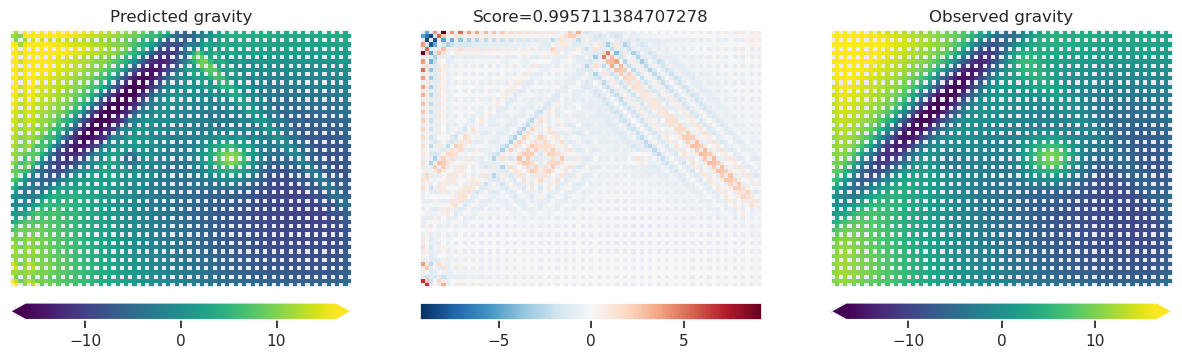

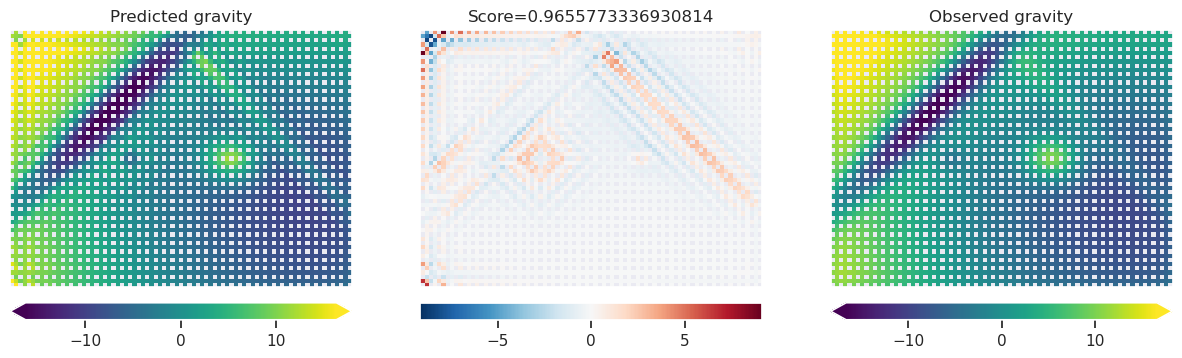

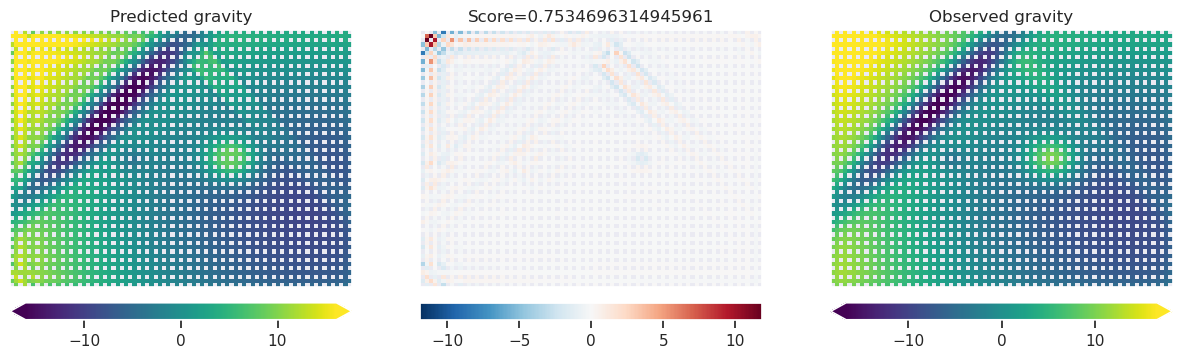

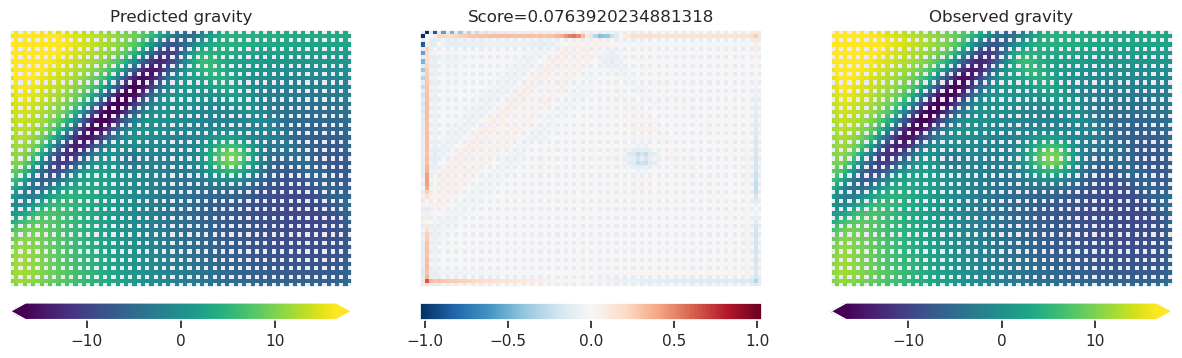

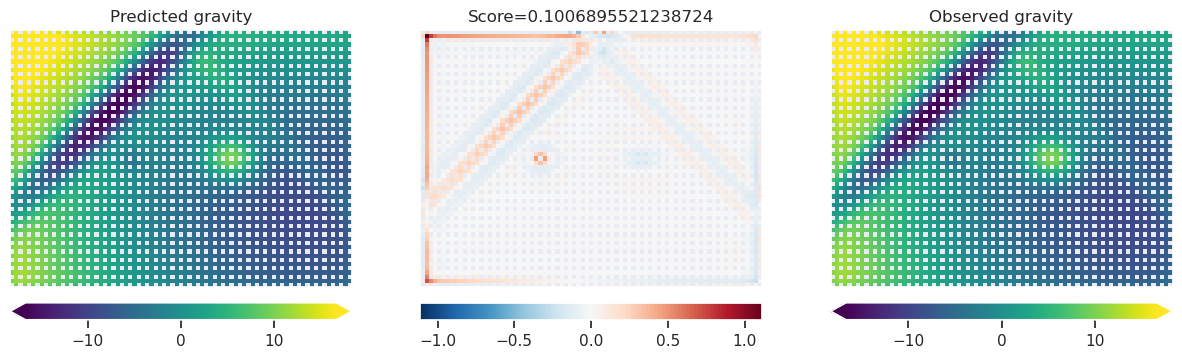

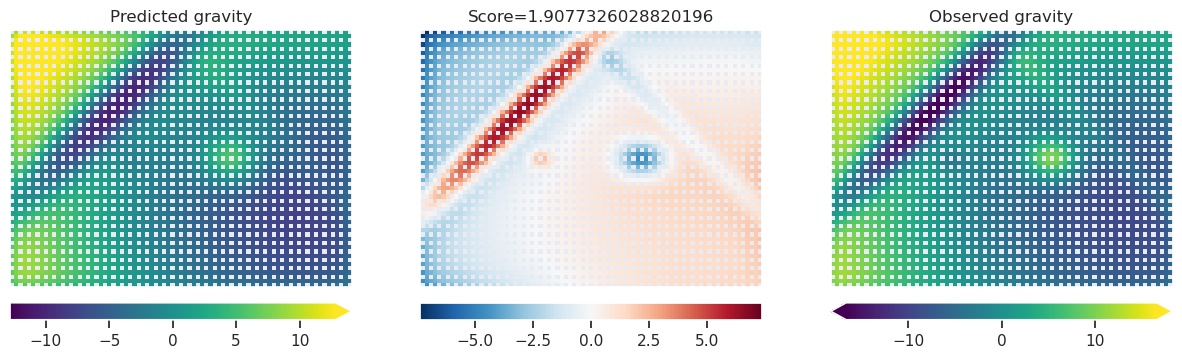

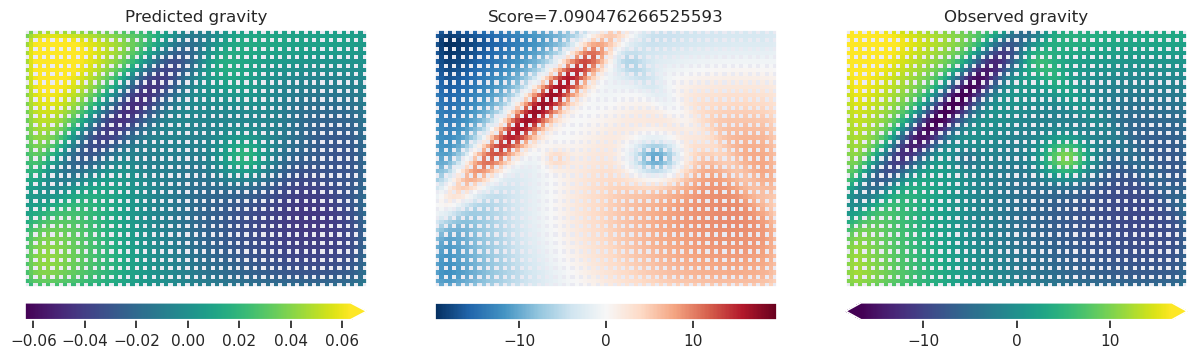

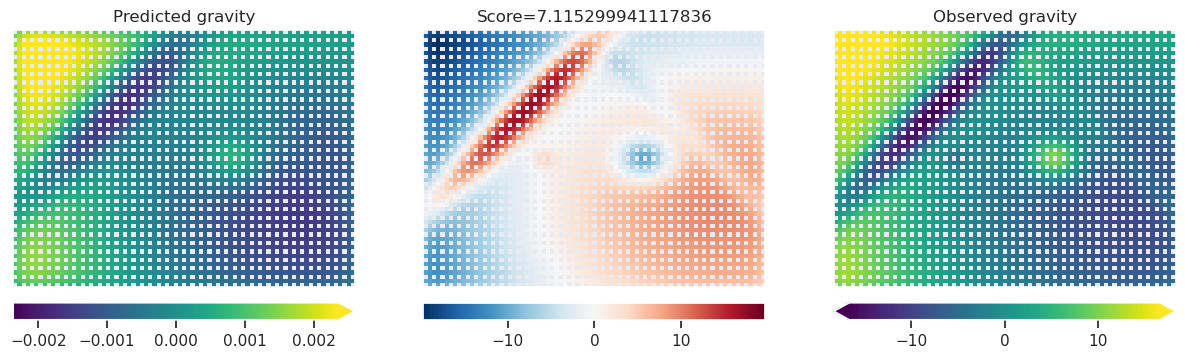

In [29]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set which damping parameters to include
dampings = np.logspace(-4, 1, 8)

best_damping, _, _, scores = cross_validation.grav_optimal_parameter(
    training_data=grav_df[grav_df.test == False],  # noqa: E712
    testing_data=grav_df[grav_df.test == True],  # noqa: E712
    param_to_test=("solver_damping", dampings),
    progressbar=True,
    plot_grids=True,
    plot_cv=False,
    verbose=True,
    **kwargs,
)

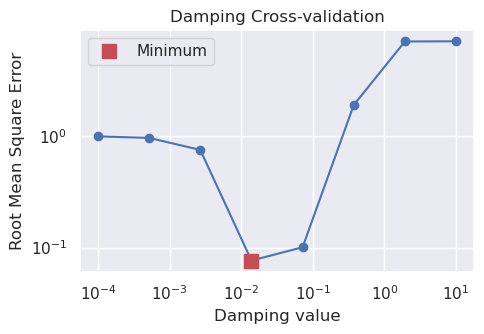

In [30]:
# Compare the scores and the damping values
plotting.plot_cv_scores(
    scores,
    dampings,
    param_name="Damping",
    logx=True,
    logy=True,
)

## Run inversion with optimal value

INFO:root:starting inversion
INFO:root:extracted prism spacing is 1000.0
INFO:root:
 #################################### 
 iteration 1


INFO:root:Layer correction median: -11.0777 m, RMSE:93.768 m
INFO:root:updated misfit RMSE: 1.2964
INFO:root:updated L2-norm: 1.1386, tolerance: 0.3
INFO:root:updated delta L2-norm : 2.3442, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 2
INFO:root:Layer correction median: -10.5485 m, RMSE:18.9752 m
INFO:root:updated misfit RMSE: 0.3457
INFO:root:updated L2-norm: 0.588, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.9364, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 3
INFO:root:Layer correction median: 1.5082 m, RMSE:5.7129 m
INFO:root:updated misfit RMSE: 0.1137
INFO:root:updated L2-norm: 0.3372, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.7436, tolerance: 1.01
INFO:root:
 #################################### 
 iteration 4
INFO:root:Layer correction median: -0.2199 m, RMSE:2.0985 m
INFO:root:updated misfit RMSE: 0.0679
INFO:root:updated L2-norm: 0.2606, tolerance: 0.3
INFO:root:updated delta L2-norm : 1.2938, to

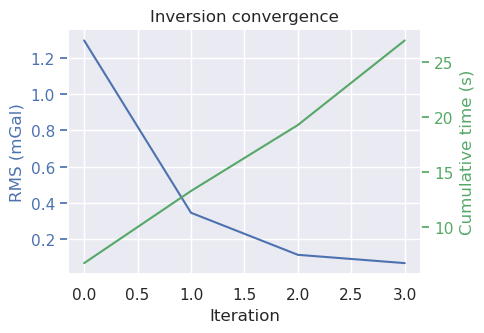

In [31]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# make new kwargs without solver damping
new_kwargs = {
    key: value
    for key, value in kwargs.items()
    if key
    not in [
        "solver_damping",
    ]
}

results = inversion.run_inversion(
    input_grav=grav_df,
    plot_convergence=True,
    solver_damping=best_damping,
    **new_kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

returning original grid
returning original grid


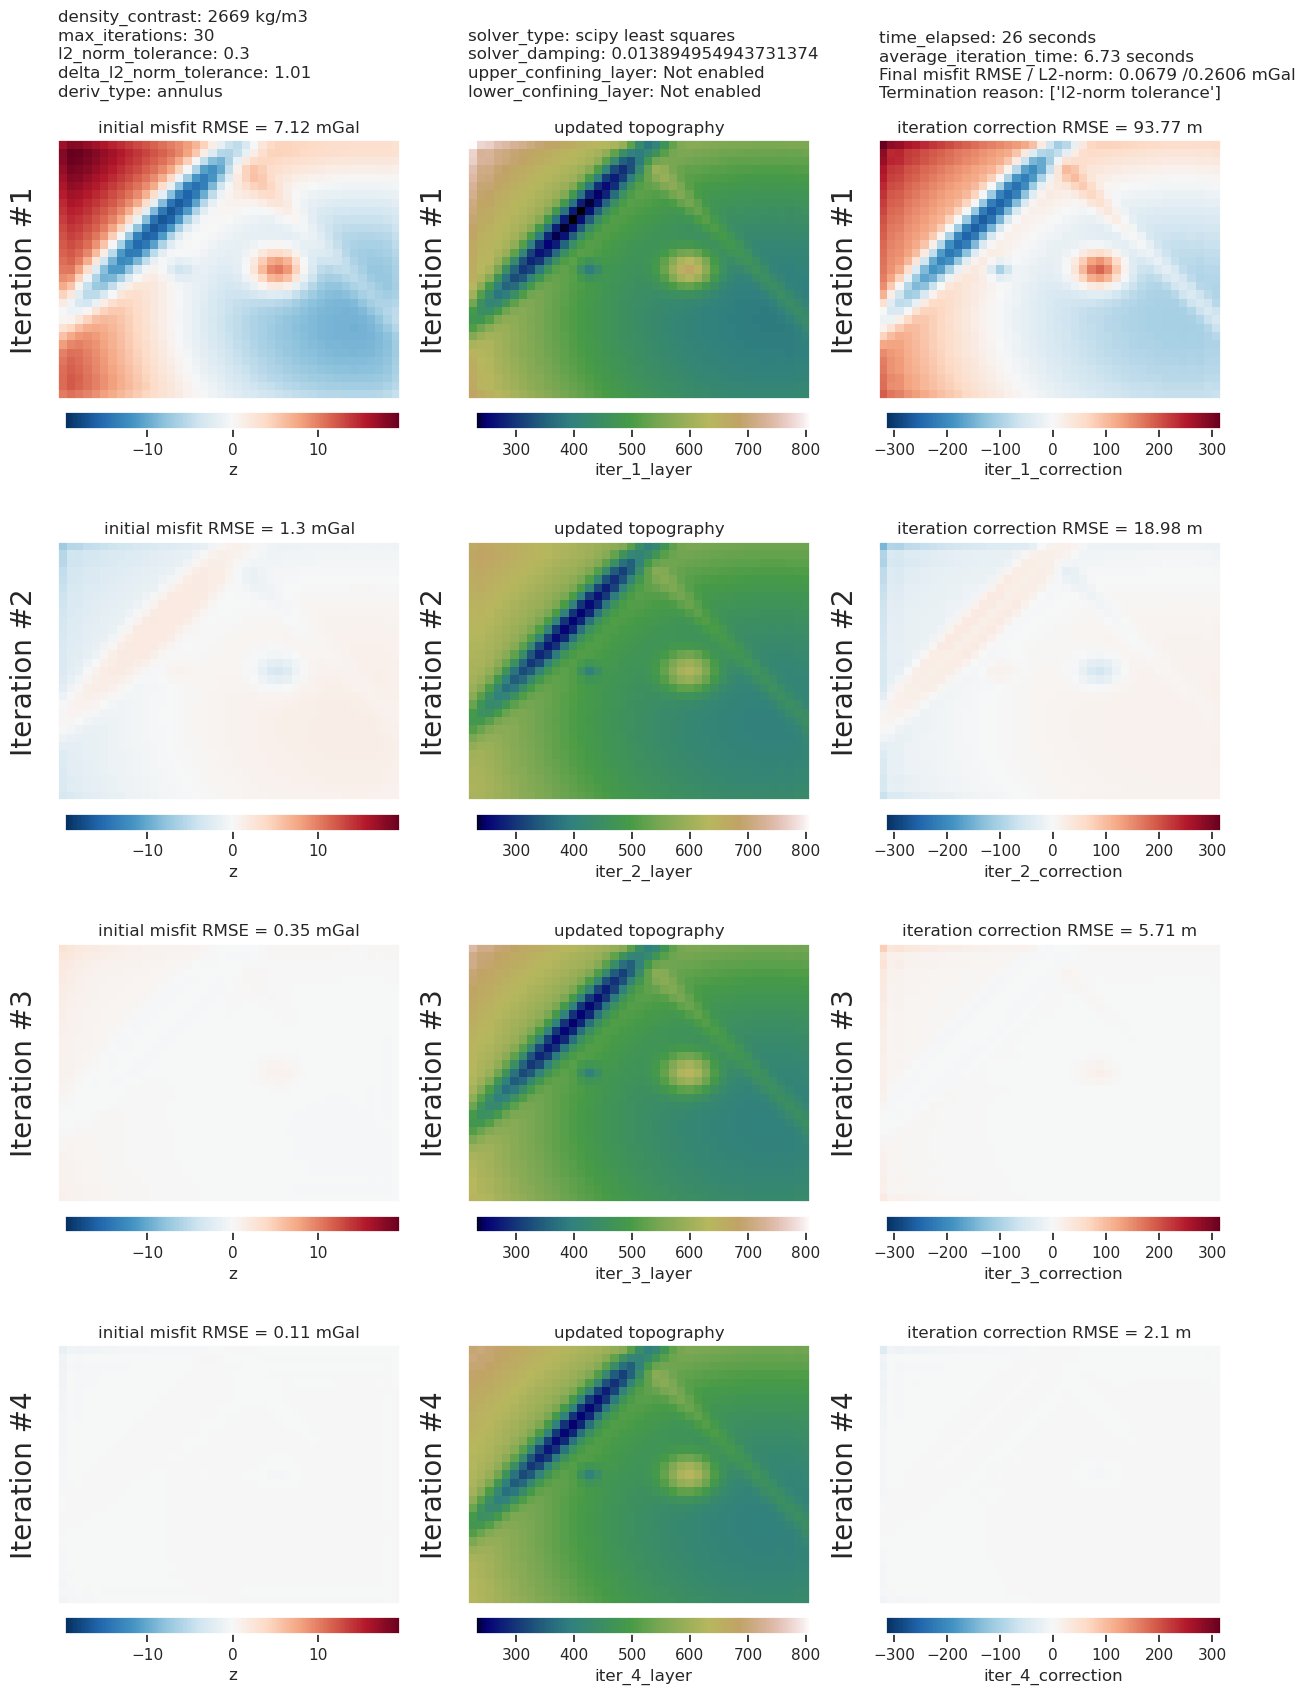

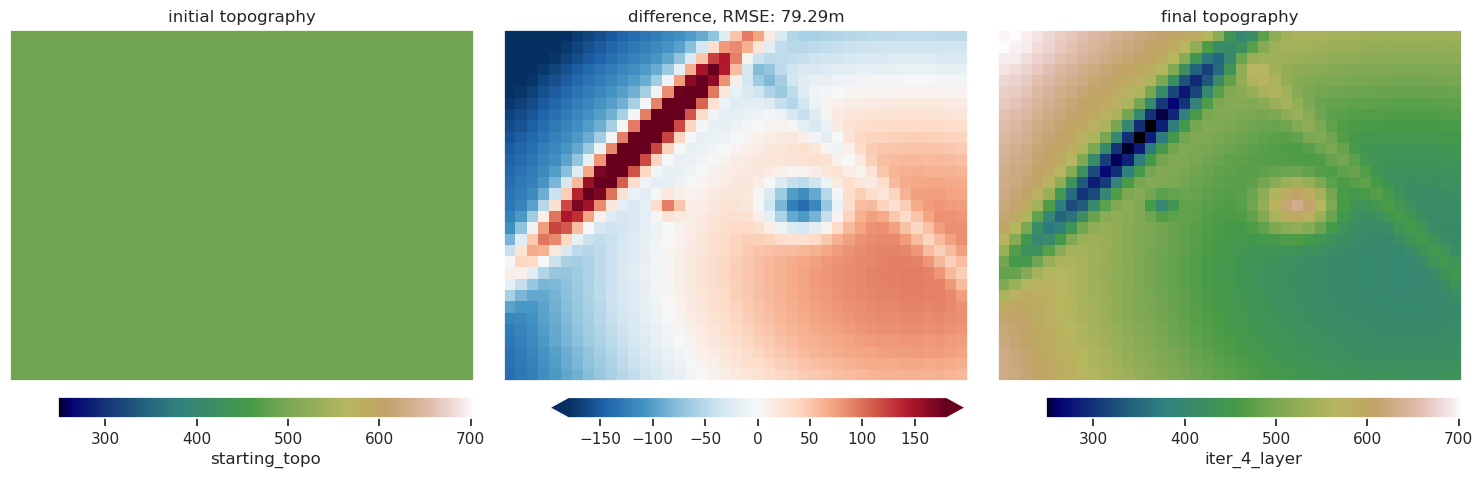

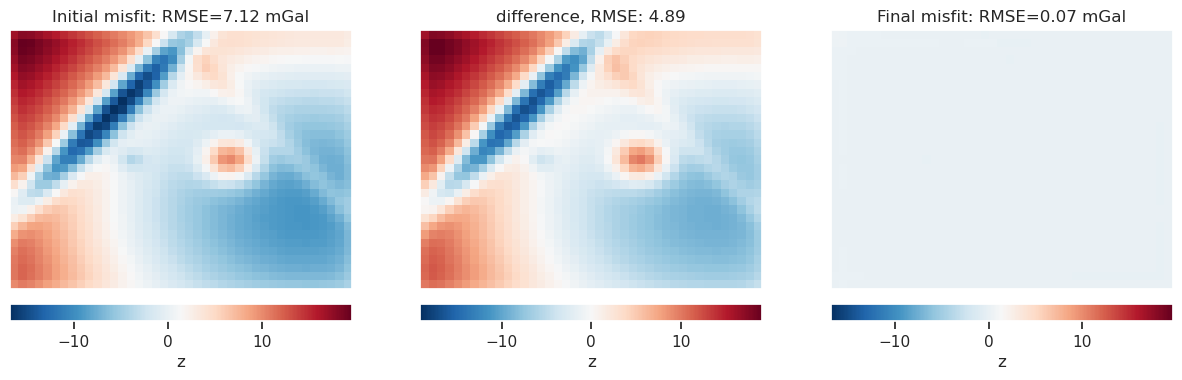

In [32]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    spacing,
    iters_to_plot=4,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

returning original grid
returning original grid


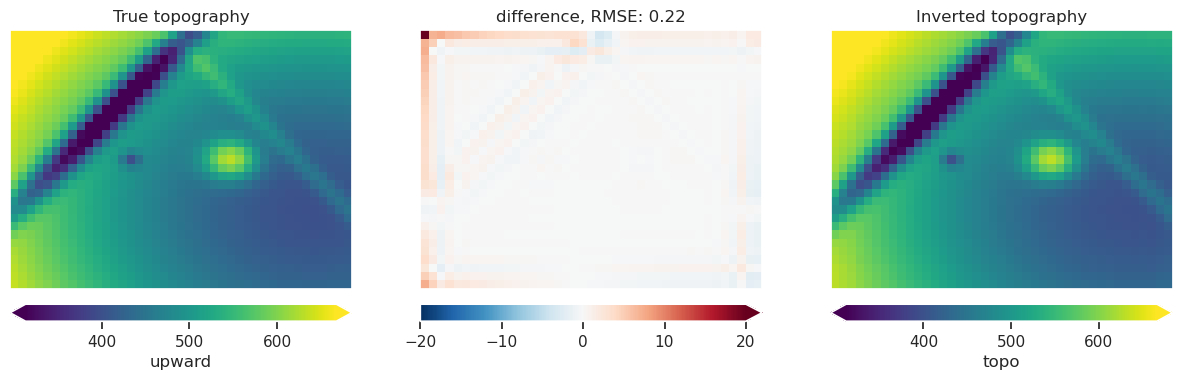

In [33]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = ap_utils.grd_compare(
    true_topography,
    final_topography,
    plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    diff_lims=(-20, 20),
)

In the past example (`simple_inversion.ipynb`), we arbitrarily chose a damping value. Here, we show how by finding the optimal damping value using a cross-validation, we have improved the inversion's performance.

The next notebook, `density_cross_validation.ipynb`, will show how to perform a similar cross validation for choosing a density contrast value.

#